# Step 1: Import Libraries and tools

In [51]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set seed for reproducibility
np.random.seed(42)

# Load the sales data
sales_data = pd.read_csv('sales_data.csv', parse_dates=['sales_date'])

# Load the new products data
new_products = pd.read_csv('new_products.csv', parse_dates=['release_date'])

logging.info("Data loading complete.")


2024-07-28 12:48:19,474 - INFO - Data loading complete.


# Step 2:Data Processing

In [52]:
# Add season feature
def add_season_feature(df, date_column):
    df['month'] = df[date_column].dt.month
    conditions = [
        (df['month'].isin([1, 2, 3])),
        (df['month'].isin([4, 5, 6])),
        (df['month'].isin([7, 8, 9])),
        (df['month'].isin([10, 11, 12]))
    ]
    choices = [1, 2, 3, 4]
    df['season'] = np.select(conditions, choices, default=0)
    df.drop('month', axis=1, inplace=True)
    return df

# Add season feature to datasets
sales_data = add_season_feature(sales_data, 'sales_date')
new_products = add_season_feature(new_products, 'release_date')

# Filter data for the past 3 years
cutoff_date = datetime.datetime.now() - datetime.timedelta(days=3*365)
sales_data_3_years = sales_data[sales_data['sales_date'] >= cutoff_date]

# Filter new products added in the past 28 days
new_items_28_days = new_products[new_products['release_date'] >= (pd.Timestamp.today() - pd.Timedelta(days=28))]

# Calculate dynamic thresholds
def calculate_thresholds(df):
    units_sold_thresholds = np.percentile(df['units_sold'], [33, 67])
    profit_thresholds = np.percentile(df['profit'], [33, 67])
    price_per_unit_thresholds = np.percentile(df['price_per_unit'], [33, 67])
    
    return {
        'units_sold': units_sold_thresholds,
        'profit': profit_thresholds,
        'price_per_unit': price_per_unit_thresholds
    }

thresholds_3_years = calculate_thresholds(sales_data_3_years)
thresholds_28_days = calculate_thresholds(new_items_28_days)

# Define dynamic thresholds for non-profitable and profitable products
def categorize_products(df, thresholds):
    non_profitable = df[
        (df['units_sold'] <= thresholds['units_sold'][0]) &
        (df['profit'] <= thresholds['profit'][0]) &
        (df['price_per_unit'] <= thresholds['price_per_unit'][0])
    ]
    
    profitable = df[
        (df['units_sold'] >= thresholds['units_sold'][1]) &
        (df['profit'] >= thresholds['profit'][1]) &
        (df['price_per_unit'] >= thresholds['price_per_unit'][1])
    ]
    
    return non_profitable, profitable

# Categorize past 3 years sales data
non_profitable_3_years, profitable_3_years = categorize_products(sales_data_3_years, thresholds_3_years)

# Categorize new products data
non_profitable_28_days, profitable_28_days = categorize_products(new_items_28_days, thresholds_28_days)

logging.info("Data processing and threshold calculation complete.")

2024-07-28 12:48:23,422 - INFO - Data processing and threshold calculation complete.


# Step 3: Model Training

In [53]:

# Encode categorical features
le_category = LabelEncoder()
sales_data_3_years['category_encoded'] = le_category.fit_transform(sales_data_3_years['category'])

# Prepare training data
X = sales_data_3_years[['category_encoded', 'price_per_unit', 'profit', 'season']]
y = sales_data_3_years['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForestRegressor for demand forecasting
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Save the model and encoders
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(le_category, 'le_category.pkl')

logging.info("Model training and saving complete.")

2024-07-28 12:48:24,939 - INFO - Model training and saving complete.


# Step 4: Data Visualizer

2024-07-28 12:48:25,702 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-28 12:48:25,710 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


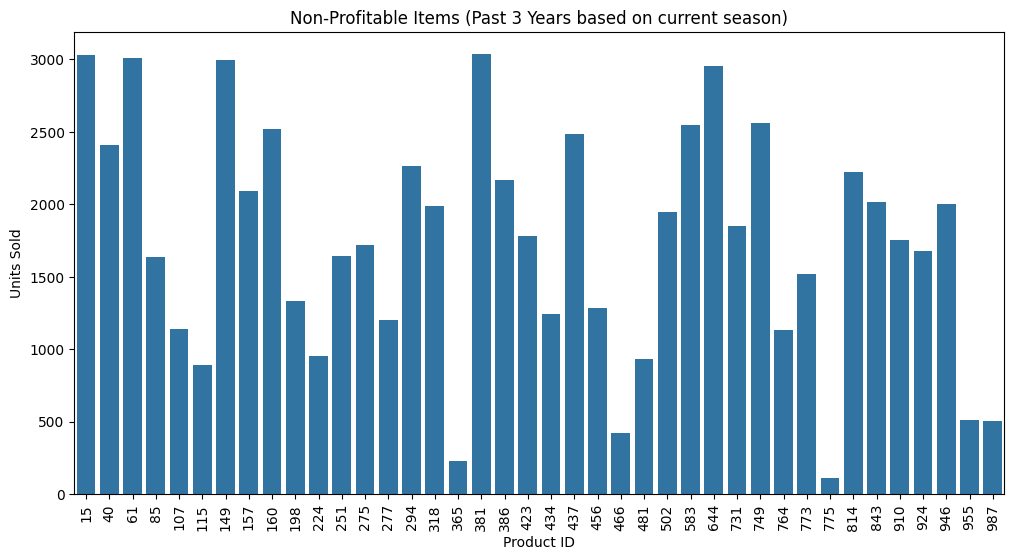

2024-07-28 12:48:26,166 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-28 12:48:26,174 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


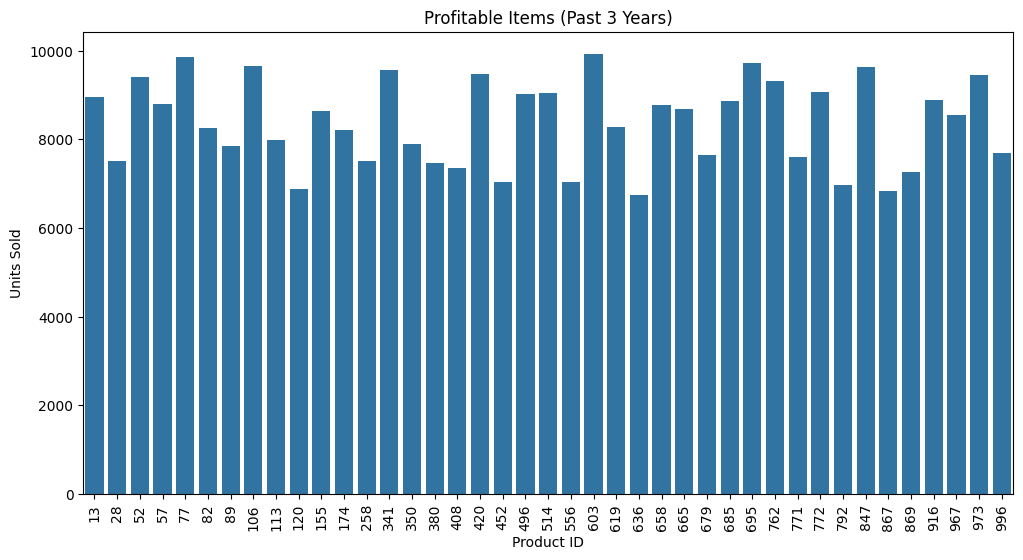

2024-07-28 12:48:26,708 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-28 12:48:26,718 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


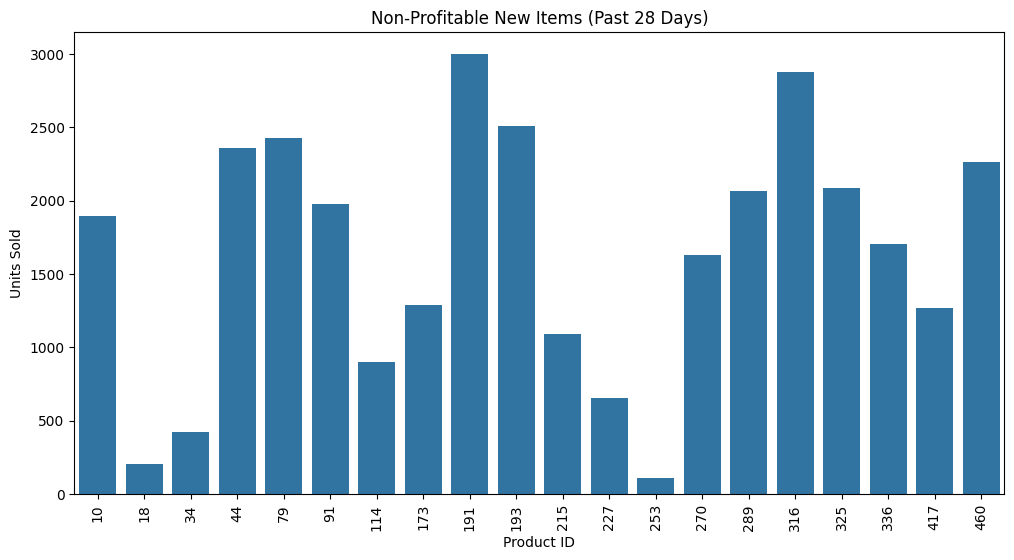

2024-07-28 12:48:27,147 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-28 12:48:27,158 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


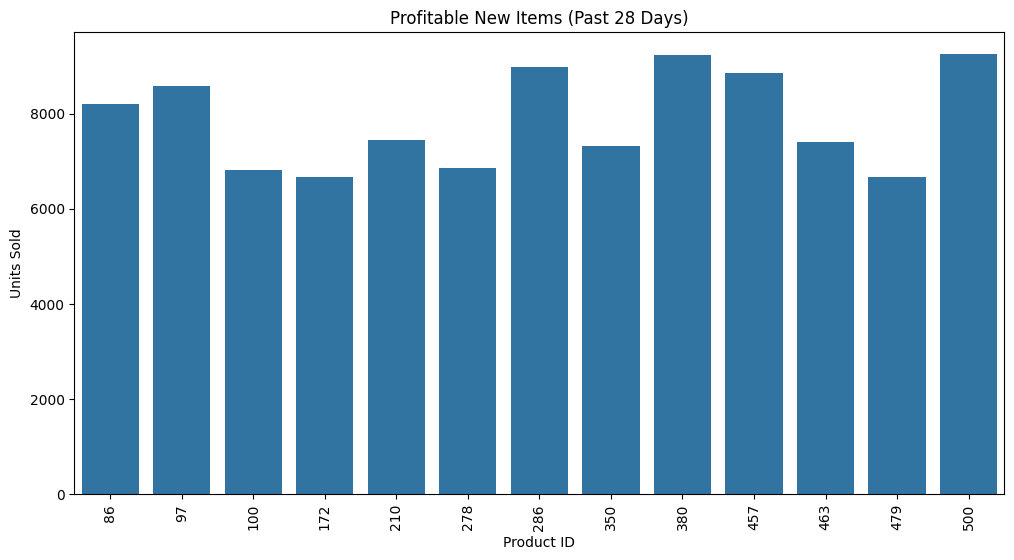

2024-07-28 12:48:27,419 - INFO - Data analysis and visualization complete.


In [54]:
 
# Load the model and encoders
rf_model = joblib.load('rf_model.pkl')
le_category = joblib.load('le_category.pkl')

# Function to predict future demand for a specific product
def predict_demand(category, price, profit, season):
    category_enc = le_category.transform([category])[0]
    prediction_input = pd.DataFrame([[category_enc, price, profit, season]], columns=['category_encoded', 'price_per_unit', 'profit', 'season'])
    return rf_model.predict(prediction_input)[0]

# Visualize non-profitable and profitable products from past 3 years
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='units_sold', data=non_profitable_3_years)
plt.title('Non-Profitable Items (Past 3 Years based on current season)')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='units_sold', data=profitable_3_years)
plt.title('Profitable Items (Past 3 Years)')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()
# Visualize non-profitable and profitable new products from past 28 days
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='units_sold', data=non_profitable_28_days)
plt.title('Non-Profitable New Items (Past 28 Days)')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='units_sold', data=profitable_28_days)
plt.title('Profitable New Items (Past 28 Days)')
plt.xlabel('Product ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

logging.info("Data analysis and visualization complete.")
